In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
symbol = 'EUR='
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [4]:
# EOD 데이터
data.head()

,EUR=
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


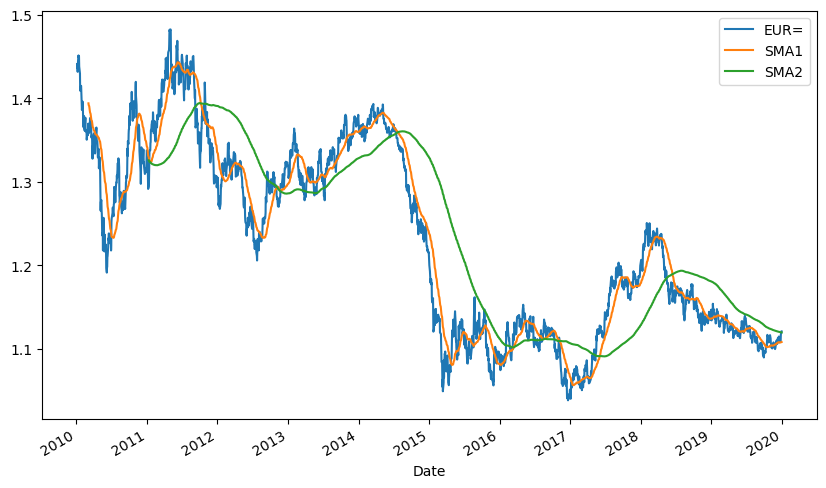

In [5]:
data['SMA1'] = data[symbol].rolling(42).mean()
data['SMA2'] = data[symbol].rolling(258).mean()
data.plot(figsize=(10, 6));

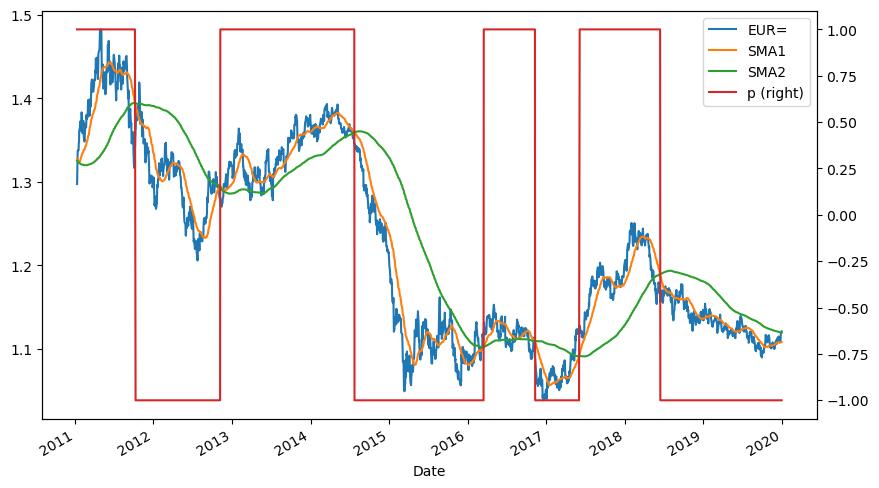

In [6]:
data.dropna(inplace=True)
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1) # positive value
data['p'] = data['p'].shift(1)
data.dropna(inplace=True)
data.plot(figsize=(10, 6), secondary_y='p');

In [7]:
# Calculates the log returns
data['r'] = np.log(data[symbol] / data[symbol].shift(1))
data.dropna(inplace=True)
# Calculates the strategy returns
data['s'] = data['p'] * data['r']

In [8]:
# Calculates the gross performances
data[['r', 's']].sum().apply(np.exp) 

r    0.863969
s    1.377344
dtype: float64

In [9]:
# Calculates the net performances
data[['r', 's']].sum().apply(np.exp) - 1

r   -0.136031
s    0.377344
dtype: float64

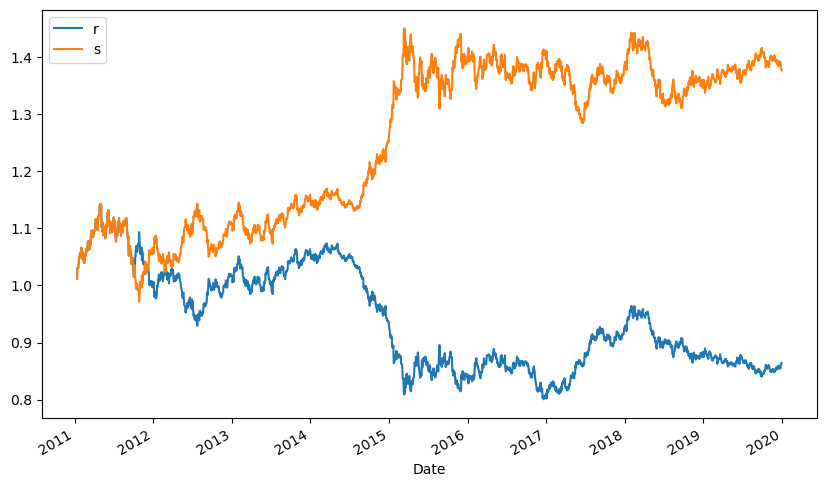

In [10]:
# Visualizes the gross performances over time
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [11]:
# Calculates the number of trades, including entry and exit trade
sum(data['p'].diff() != 0) + 2

10

In [12]:
# Fixes the proportional transaction costs (deliberately set quite high)
pc = 0.005

In [13]:
# Adjusts the strategy performance for the transaction costs
data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])
# Adjusts the strategy performance for the entry trade
data['s_'].iloc[0] -= pc
# Adjusts the strategy performance for the exit trade
data['s_'].iloc[-1] -= pc
# Shows the adjusted performance values for the regular trades
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.012256,0.012256,0.002256
2011-10-10,0.019766,-0.019766,-0.024766
2012-11-07,-0.003362,-0.003362,-0.008362
2014-07-24,-0.000074,0.000074,-0.004926
2016-03-16,0.010211,0.010211,0.005211
2016-11-10,-0.001835,0.001835,-0.003165
2017-06-05,-0.002485,-0.002485,-0.007485
2018-06-15,0.003452,-0.003452,-0.008452


In [14]:
data[['r', 's', 's_']].sum().apply(np.exp)

r     0.863969
s     1.377344
s_    1.310171
dtype: float64

In [15]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.136031
s     0.377344
s_    0.310171
dtype: float64

In [16]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.136031
s     0.377344
s_    0.310171
dtype: float64

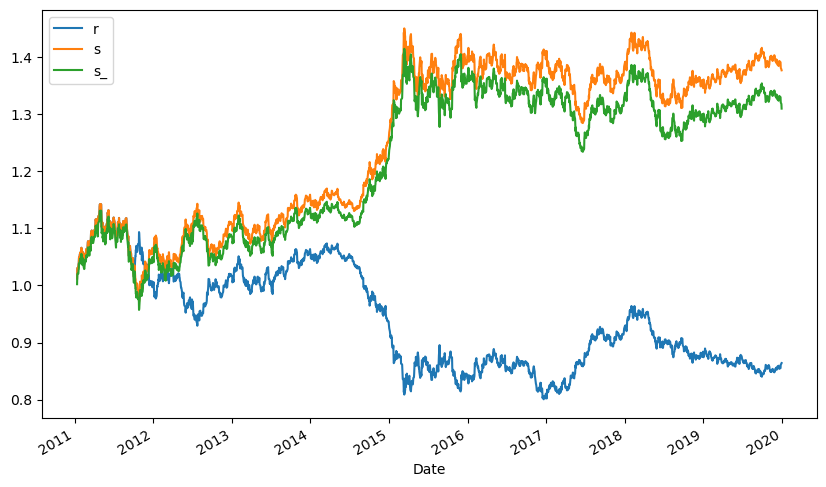

In [17]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [18]:
# Daily volatility
data[['r', 's', 's_']].std()

r     0.005375
s     0.005374
s_    0.005384
dtype: float64

In [19]:
# Annualized volatility
data[['r', 's', 's_']].std() * math.sqrt(252)

r     0.085333
s     0.085309
s_    0.085472
dtype: float64

In [20]:
# Backtesting a Daily DNN-Based Strategy

In [21]:
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

In [22]:
lags = 5

def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [23]:
data, cols = add_lags(data, symbol, lags, window=20)

In [24]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [25]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

In [26]:
optimizer = Adam(learning_rate=0.0001)

In [27]:
def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                regularize=False, reg=l1(0.0005),
                optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    return model

In [28]:
# Splits the data into training and test data
split = '2018-01-01'

# Shows the frequency of the labels classes
train = data.loc[:split].copy()

In [29]:
np.bincount(train['d'])

array([ 982, 1006], dtype=int64)

In [30]:
# Normalizes the training features data
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [31]:
set_seeds()
# Creates the DNN model
model = create_model(hl=2, hu=64)

In [32]:
# Trains the DNN model on the training data
%%time
model.fit(train_[cols], train['d'],
            epochs=20, verbose=False,
            validation_split=0.2, shuffle=False)

CPU times: total: 8.77 s
Wall time: 6.65 s


In [33]:
# Evaluates the performance of the model on the training data
model.evaluate(train_[cols], train['d'])

63/63 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5855


[0.6740418076515198, 0.5855130553245544]

In [34]:
# Generates the binary predictions
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0)
# Translates the predictions into position values
train['p'] = np.where(train['p'] == 1, 1, -1) 

63/63 [==============================] - 0s 3ms/step


In [35]:
# Shows the number of long and short positions
train['p'].value_counts()

-1    1070
 1     918
Name: p, dtype: int64

In [36]:
# Calculates the strategy performance values
train['s'] = train['p'] * train['r']

In [37]:
# Calculates the gross and net performances (in-sample)
train[['r', 's']].sum().apply(np.exp)

r    0.878699
s    5.103826
dtype: float64

In [38]:
train[['r', 's']].sum().apply(np.exp) - 1

r   -0.121301
s    4.103826
dtype: float64

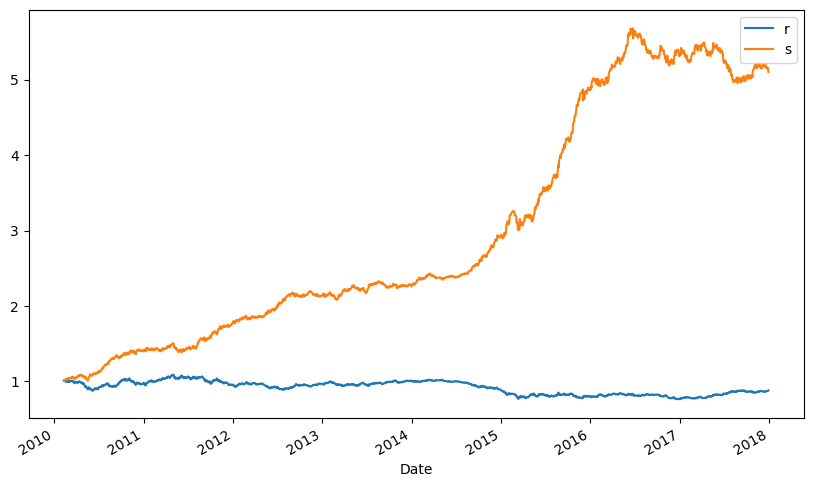

In [40]:
# Visualizes the gross performances over time (in-sample)
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [41]:
# Generates the test data sub-set
test = data.loc[split:].copy()

# Normalizes the test data 
test_ = (test - mu) / std

# Evaluates the model performance on the test data
model.evaluate(test_[cols], test['d'])

16/16 [==============================] - 0s 3ms/step - loss: 0.6935 - accuracy: 0.5328


[0.6935049891471863, 0.5328031778335571]

In [42]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

16/16 [==============================] - 0s 3ms/step


In [43]:
test['p'].value_counts()

-1    404
 1     99
Name: p, dtype: int64

In [44]:
test['s'] = test['p'] * test['r']

In [45]:
test[['r', 's']].sum().apply(np.exp)

r    0.934478
s    1.290209
dtype: float64

In [46]:
test[['r', 's']].sum().apply(np.exp) - 1

r   -0.065522
s    0.290209
dtype: float64

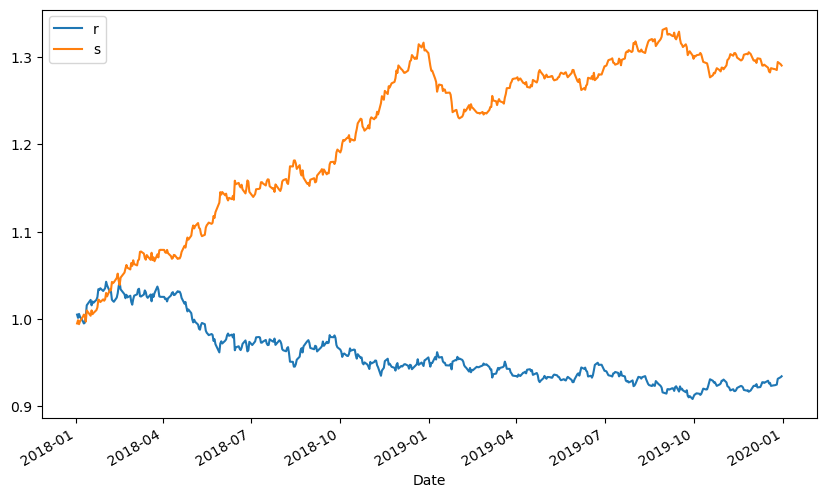

In [47]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [48]:
sum(test['p'].diff() != 0)

149

In [49]:
# Fixes the average bid-ask spread
spread = 0.00012
# Calculates the average proportional transaction costs
pc = spread / data[symbol].mean() 
print(f'{pc:.6f}')

0.000098


In [50]:
test['s_'] = np.where(test['p'].diff() != 0, test['s'] - pc, test['s'])
test['s_'].iloc[0] -= pc
test['s_'].iloc[-1] -= pc

C:\Users\hong9\AppData\Local\Temp\ipykernel_21804\388131191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_'].iloc[0] -= pc
C:\Users\hong9\AppData\Local\Temp\ipykernel_21804\388131191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_'].iloc[-1] -= pc


In [51]:
test[['r', 's', 's_']].sum().apply(np.exp)

r     0.934478
s     1.290209
s_    1.271326
dtype: float64

In [52]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.065522
s     0.290209
s_    0.271326
dtype: float64

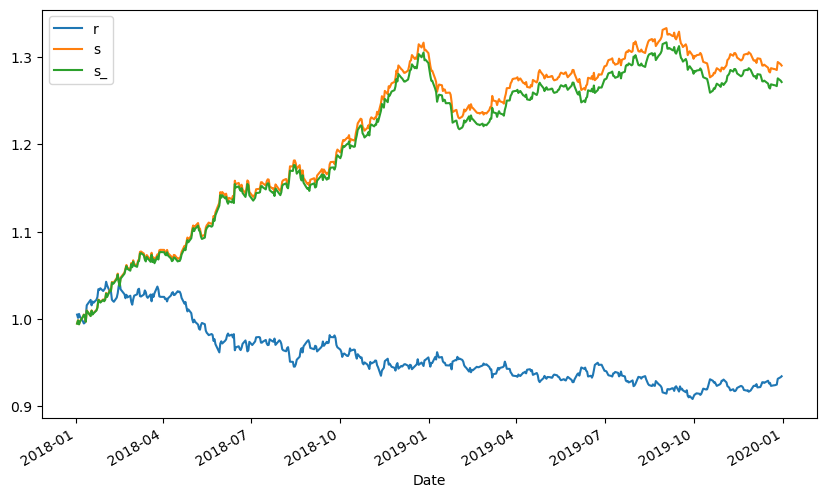

In [53]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [54]:
# Backtesting an Intraday DNN-Based Strategy

In [83]:
# Intraday data
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR='
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()['CLOSE']) 
data.columns = [symbol]
data.head()

,EUR=
Date,
2019-10-01 00:00:00,1.0899
2019-10-01 00:01:00,1.0898
2019-10-01 00:02:00,1.0896
2019-10-01 00:03:00,1.0898
2019-10-01 00:04:00,1.0898


In [84]:
data = data.resample('5min', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26486 entries, 2019-10-01 00:05:00 to 2019-12-31 23:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    26486 non-null  float64
dtypes: float64(1)
memory usage: 413.8 KB


In [85]:
lags = 5
data, cols = add_lags(data, symbol, lags, window=20)

In [86]:
split = int(len(data) * 0.85)
train = data.iloc[:split].copy()
np.bincount(train['d'])

array([16284,  6207], dtype=int64)

In [87]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [88]:
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

In [89]:
set_seeds()
model = create_model(hl=1, hu=128,
                    reg=True, dropout=False)

In [90]:
%%time
model.fit(train_[cols], train['d'],
            epochs=40, verbose=False,
            validation_split=0.2, shuffle=False,
            class_weight=cw(train))

CPU times: total: 2min 22s
Wall time: 1min 29s


In [91]:
model.evaluate(train_[cols], train['d'])

703/703 [==============================] - 2s 3ms/step - loss: 0.5215 - accuracy: 0.6748


[0.5215124487876892, 0.674758791923523]

In [92]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)

703/703 [==============================] - 2s 3ms/step


In [93]:
train['p'].value_counts()

-1    11353
 1    11138
Name: p, dtype: int64

In [94]:
train['s'] = train['p'] * train['r']

In [95]:
train[['r', 's']].sum().apply(np.exp)

r    1.022316
s    1.675346
dtype: float64

In [96]:
train[['r', 's']].sum().apply(np.exp) - 1

r    0.022316
s    0.675346
dtype: float64

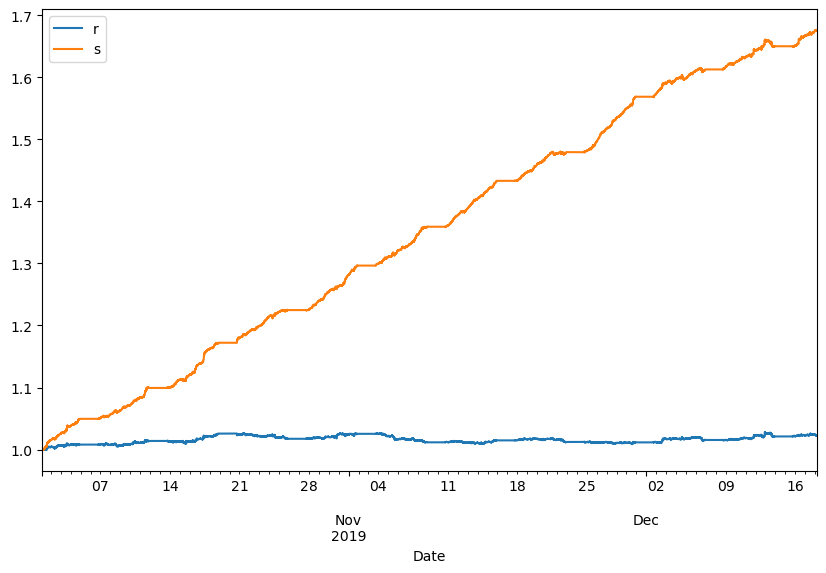

In [97]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [98]:
test = data.iloc[split:].copy()
test_ = (test - mu) / std

In [99]:
model.evaluate(test_[cols], test['d'])

125/125 [==============================] - 0s 3ms/step - loss: 0.5251 - accuracy: 0.6670


[0.5251153111457825, 0.6670024991035461]

In [100]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)

125/125 [==============================] - 0s 2ms/step


In [101]:
test['p'].value_counts()

-1    2199
 1    1771
Name: p, dtype: int64

In [102]:
test['s'] = test['p'] * test['r']

In [103]:
test[['r', 's']].sum().apply(np.exp)

r    1.007097
s    1.064747
dtype: float64

In [104]:
test[['r', 's']].sum().apply(np.exp) - 1

r    0.007097
s    0.064747
dtype: float64

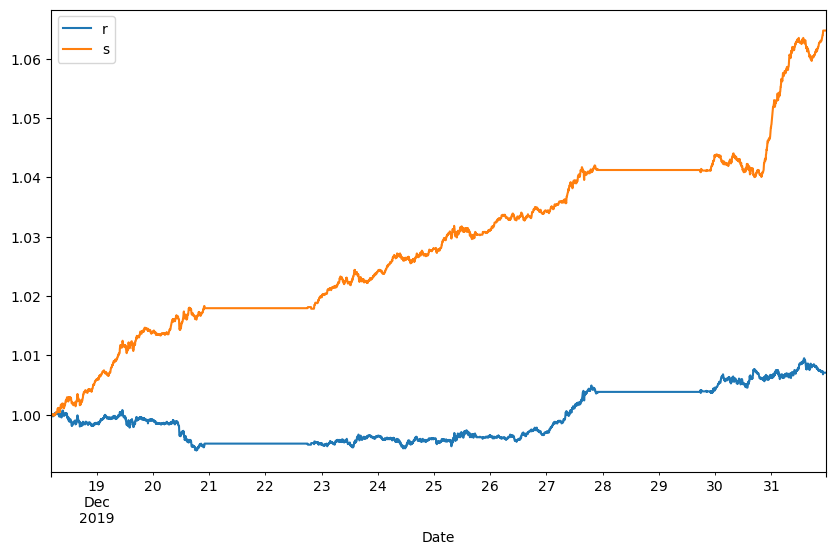

In [105]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [106]:
sum(test['p'].diff() != 0)
# Assumes bid-ask spread on retail level
spread = 0.00012 
pc_1 = spread / test[symbol]

In [107]:
# Assumes bid-ask spread on professional level
spread = 0.00006
pc_2 = spread / test[symbol] 

In [108]:
test['s_1'] = np.where(test['p'].diff() != 0, test['s'] - pc_1, test['s'])
test['s_2'] = np.where(test['p'].diff() != 0, test['s'] - pc_2, test['s'])

In [109]:
test['s_1'].iloc[0] -= pc_1.iloc[0] 
test['s_1'].iloc[-1] -= pc_1.iloc[0]

test['s_2'].iloc[0] -= pc_2.iloc[0] 
test['s_2'].iloc[-1] -= pc_2.iloc[0]

C:\Users\hong9\AppData\Local\Temp\ipykernel_21804\479991246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_1'].iloc[0] -= pc_1.iloc[0]
C:\Users\hong9\AppData\Local\Temp\ipykernel_21804\479991246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_1'].iloc[-1] -= pc_1.iloc[0]
C:\Users\hong9\AppData\Local\Temp\ipykernel_21804\479991246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['s_2'].iloc[0] -= pc_2.il

In [110]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

r      1.007097
s      1.064747
s_1    0.933782
s_2    0.997117
dtype: float64

In [111]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp) - 1

r      0.007097
s      0.064747
s_1   -0.066218
s_2   -0.002883
dtype: float64

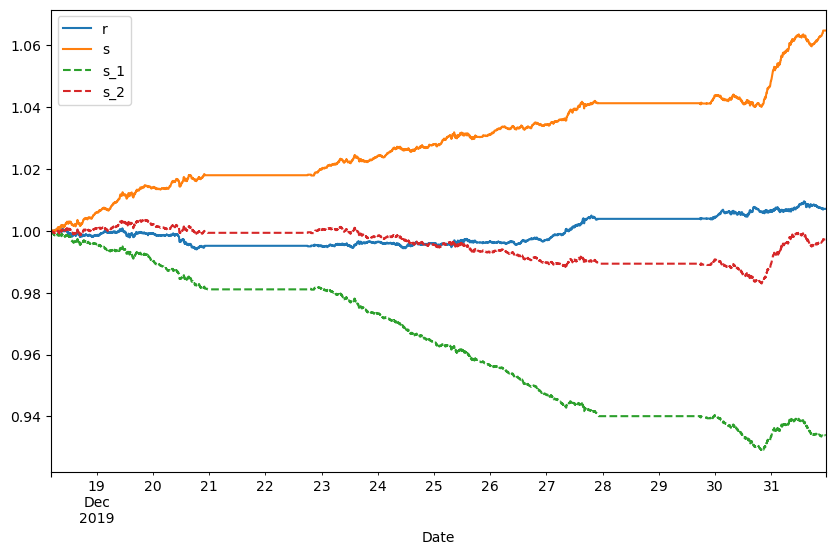

In [112]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(np.exp).plot(figsize=(10, 6), style=['-', '-', '--', '--']);